<a href="https://colab.research.google.com/github/RajSinha77/DL-Reg-implementation-/blob/main/DLReg_vs_L2_on_Oxford_IIIT_Pet_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3680
    })
    test: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3669
    })
})
Epoch 1/25, Train Acc: 0.07282608695652174, Val Acc: 0.1632597437994004
Epoch 2/25, Train Acc: 0.4459239130434783, Val Acc: 0.7773235213954757
Epoch 3/25, Train Acc: 0.866304347826087, Val Acc: 0.8552739165985282
Epoch 4/25, Train Acc: 0.9222826086956522, Val Acc: 0.8607249931861543
Epoch 5/25, Train Acc: 0.9505434782608696, Val Acc: 0.8765331152902699
Epoch 6/25, Train Acc: 0.9709239130434782, Val Acc: 0.9010629599345871
Epoch 7/25, Train Acc: 0.9758152173913044, Val Acc: 0.9024257290814937
Epoch 8/25, Train Acc: 0.9858695652173913, Val Acc: 0.9032433905696375
Epoch 9/25, Train Acc: 0.99375, Val Acc: 0.9021531752521124
Epoch 10/25, Train Acc: 0.997554347826087, Val Acc: 0.9114200054510766
Epoch 11/25, Train Acc: 0.9991847826086957, Val A

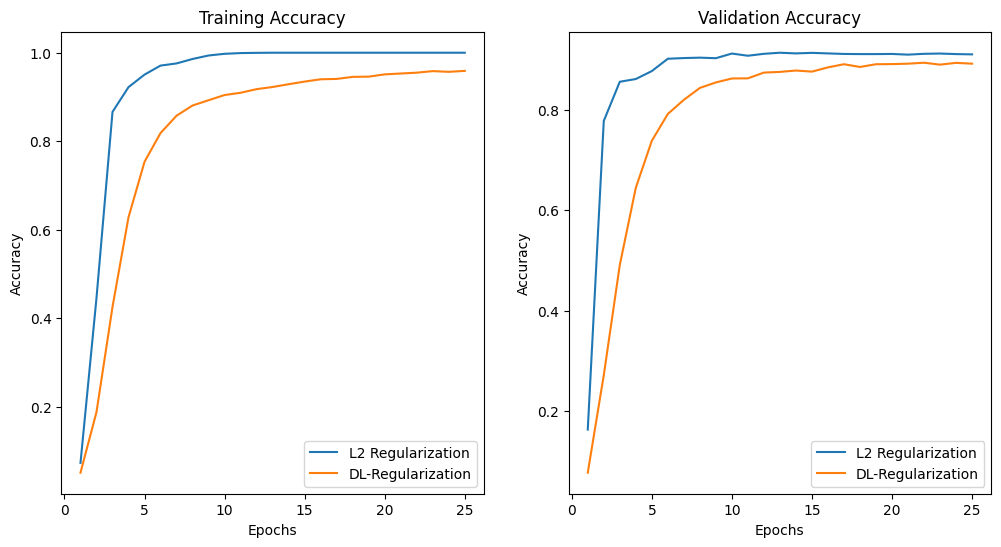

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# Define constants
BATCH_SIZE = 64
NUM_EPOCHS = 25
LEARNING_RATE = 0.001

# Load the Oxford-IIIT Pet dataset from Hugging Face
dataset = load_dataset('timm/oxford-iiit-pet')

# Print the dataset structure to check available splits
print(dataset)

# Identify the correct splits
train_split = 'train'
val_split = 'test'

# Custom dataset class to handle Hugging Face dataset
class OxfordIIITPetDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations for the Oxford-IIIT Pet dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode != "RGB" else x),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare the dataset and dataloaders
train_dataset = OxfordIIITPetDataset(dataset[train_split], transform=transform)
val_dataset = OxfordIIITPetDataset(dataset[val_split], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the models with updated weights parameter
resnet152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Modify the final layers to fit Oxford-IIIT Pet classes (37 classes)
num_ftrs_resnet = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs_resnet, 37)

num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs_densenet, 37)

# Define DL-Regularization
class DLRegularization(nn.Module):
    def __init__(self, model, lambda_reg=0.001):
        super(DLRegularization, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg

    def forward(self, x):
        output = self.model(x)
        return output

    def dl_reg_loss(self, x, output):
        batch_size = x.size(0)
        Z = nn.Linear(x.view(batch_size, -1).size(1), output.size(1), bias=False).to(x.device)
        reg_loss = torch.norm(Z(x.view(batch_size, -1)) - output) ** 2
        return self.lambda_reg * reg_loss

# Training function
def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS, dl_regularizer=None):
    model.train()
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if dl_regularizer:
                reg_loss = dl_regularizer.dl_reg_loss(inputs, outputs)
                loss += reg_loss

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(train_dataset)
        train_acc.append(epoch_acc.item())

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_acc = val_corrects.double() / len(val_dataset)
        val_acc.append(epoch_val_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {epoch_acc.item()}, Val Acc: {epoch_val_acc.item()}')

    return train_acc, val_acc

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experiment with L2 regularization
resnet152 = resnet152.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet152.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
train_acc_l2, val_acc_l2 = train_model(resnet152, criterion, optimizer)

# Experiment with DL-Regularization
densenet = densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=LEARNING_RATE)
dl_regularizer = DLRegularization(densenet, lambda_reg=0.001)
train_acc_dl, val_acc_dl = train_model(densenet, criterion, optimizer, dl_regularizer=dl_regularizer)

# Plotting the results
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_l2, label='L2 Regularization')
plt.plot(epochs, train_acc_dl, label='DL-Regularization')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_acc_l2, label='L2 Regularization')
plt.plot(epochs, val_acc_dl, label='DL-Regularization')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
